# Single Strain Analysis: *Alteromonas macleodii* HOT1A3

In [222]:
import cobra
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

In [197]:
import gem2cue.utils

In [226]:
# Make a custom color map
def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = matplotlib.colors.LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

cmap2 = CustomCmap([0.5686, 0.8314, 0.8627], [0, 0.2588, 0.388]) # from Light blue to Dark blue

In [198]:
# Read in the strain
am_strain = gem2cue.utils.Strain('HOT1A3',
                                 cobra.io.read_sbml_model('IAMM_models/models/MMB1-LB.xml'),
                                 {'GC Content': 0.446714,
                                  'Genome Length': 4801807,
                                  'Memote Score': 0.71,
                                  'Purely Metabolic Rxns': 0.5993})

## Grow on Glucose

In [199]:
glc_10_media = gem2cue.utils.Media({
 'EX_aso3_e': 1000.0,
 'EX_aso4_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 10.0, # Glucose
 'EX_glc__aD_e': 10.0, # Alpha glucose
 'EX_h2_e': 1000.0,
 'EX_h2o2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h2s_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_no2_e': 1000.0,
 'EX_no3_e': 1000.0,
 'EX_no_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_ppi_e': 1000.0, # Diphosphate
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so3_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tsul_e': 1000.0,
 'EX_zn2_e': 1000.0})

In [270]:
am_strain.update_medium(glc_10_media)

In [271]:
am_exp = gem2cue.utils.Experiment(am_strain)

### Sankey Plot

In [202]:
# am_exp.sankey(biomass_rxn='Growth')

### Biomass and CUE with varying conditions

In [272]:
data = []
for glc in range(5, 16):
  # Update glucose and oxygen in medium
  medium = am_strain.model.medium
  medium['EX_glc__D_e'] = glc
  for o2 in np.linspace(0, 25, 5):
    medium['EX_o2_e'] = o2
    am_strain.model.medium = medium
    for vm in np.linspace(0, 20, 5):
      # Update maintainance flux
      am_strain.model.reactions.ATPM.lower_bound = vm

      # Calculate rCUE
      exp = gem2cue.utils.Experiment(am_strain)
      exp.CUE(ex_nomenclature = {'C_e'})
      
      # Save
      d = {'glc': glc, 'o2': o2, 'vm': vm, 'biomass': exp.solution.objective_value, 'cue': exp.cue}
      data.append(d)

In [273]:
df = pd.DataFrame(data)
df.head()

,glc,o2,vm,biomass,cue
0,5,0.0,0.0,1.500330e-14,7.105427e-15
1,5,0.0,5.0,1.541854e-14,8.659740e-15
2,5,0.0,10.0,1.711069e-14,1.121325e-14
3,5,0.0,15.0,1.458806e-14,3.552714e-15
4,5,0.0,20.0,1.608916e-14,5.440093e-15


In [253]:
df

,glc,o2,vm,biomass,cue
0,5,0.0,0.0,-6.158513e-16,1.587619e-14
1,5,0.0,5.0,-5.655392e-17,8.992806e-15
2,5,0.0,10.0,-5.969999e-16,1.809664e-14
3,5,0.0,15.0,-9.425654e-17,1.998401e-14
4,5,0.0,20.0,-9.425654e-17,1.953993e-14
...,...,...,...,...,...
270,15,25.0,0.0,1.441552e+00,6.572618e-01
271,15,25.0,5.0,1.412721e+00,6.441165e-01
272,15,25.0,10.0,1.383890e+00,6.309713e-01
273,15,25.0,15.0,1.355059e+00,6.178261e-01


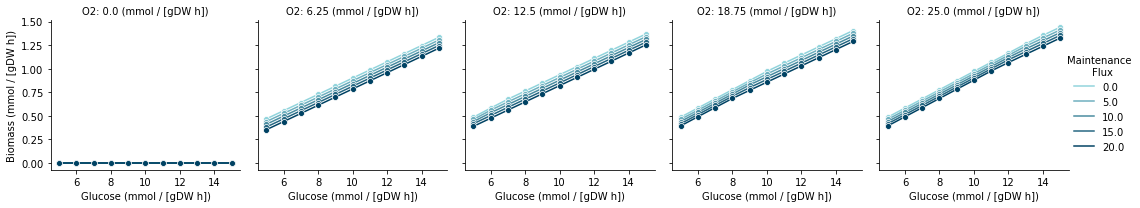

In [274]:
"Visualize biomass"
g = sns.relplot(x='glc', y='biomass', hue='vm', col='o2', data=df, kind='line', marker='o', height=3, palette=cmap2)
g.set_axis_labels("Glucose (mmol / [gDW h])", "Biomass (mmol / [gDW h])")
g.set_titles("O2: {col_name} (mmol / [gDW h])")
g._legend.set_title('Maintenance\n        Flux')
plt.show()

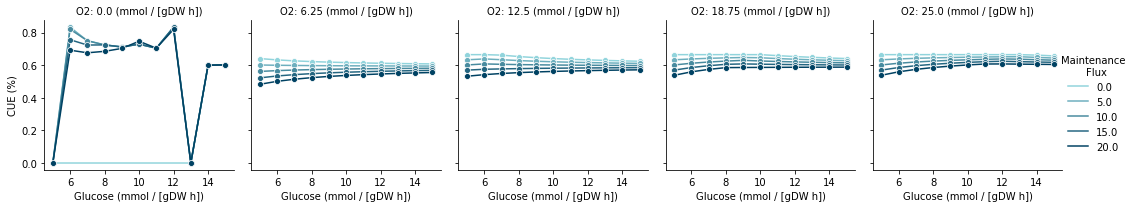

In [275]:
"Visualize CUE"
g = sns.relplot(x='glc', y='cue', hue='vm', col='o2', data=df, kind='line',
				marker='o', height=3, palette=cmap2)
g.set_axis_labels("Glucose (mmol / [gDW h])", "CUE (%)")
g.set_titles("O2: {col_name} (mmol / [gDW h])")
g._legend.set_title('Maintenance\n        Flux')
g._legend
plt.show()

## Grow on Acetate

In [208]:
ace_10_media = gem2cue.utils.Media({
 'EX_ac_e': 10.0,
 'EX_aso3_e': 1000.0,
 'EX_aso4_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2_e': 1000.0,
 'EX_h2o2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h2s_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_no2_e': 1000.0,
 'EX_no3_e': 1000.0,
 'EX_no_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_ppi_e': 1000.0, # Diphosphate
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so3_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tsul_e': 1000.0,
 'EX_zn2_e': 1000.0})

In [212]:
am_strain.update_medium(glc_10_media)

In [213]:
ace_exp = gem2cue.utils.Experiment(am_strain)

### CUE with varying conditions

In [258]:
data = []
for ac in range(5, 16):
  # Update acetate and oxygen in medium
  medium = am_strain.model.medium
  medium['EX_ac_e'] = ac
  for o2 in np.linspace(0, 25, 5):
    medium['EX_o2_e'] = o2
    am_strain.model.medium = medium
    for vm in np.linspace(0, 20, 5):
      # Update maintainance flux
      am_strain.model.reactions.ATPM.lower_bound = vm

      # Calculate rCUE
      exp = gem2cue.utils.Experiment(am_strain)
      exp.CUE(ex_nomenclature = {'C_e'})
      
      # Save
      d = {'ac': ac, 'o2': o2, 'vm': vm, 'biomass': exp.solution.objective_value, 'cue': exp.cue}
      data.append(d)

In [264]:
df = pd.DataFrame(data)
df.head()

,ac,o2,vm,biomass,cue
0,5,0.0,0.0,1.841933e-15,1.110223e-16
1,5,0.0,5.0,4.809908e-16,-2.442491e-15
2,5,0.0,10.0,1.842182e-15,-4.218847e-15
3,5,0.0,15.0,-8.801174e-16,-4.884981e-15
4,5,0.0,20.0,3.203207e-15,-1.998401e-15


In [265]:
df

,ac,o2,vm,biomass,cue
0,5,0.0,0.0,1.841933e-15,1.110223e-16
1,5,0.0,5.0,4.809908e-16,-2.442491e-15
2,5,0.0,10.0,1.842182e-15,-4.218847e-15
3,5,0.0,15.0,-8.801174e-16,-4.884981e-15
4,5,0.0,20.0,3.203207e-15,-1.998401e-15
...,...,...,...,...,...
270,15,25.0,0.0,1.787524e+00,6.112534e-01
271,15,25.0,5.0,1.758693e+00,6.013945e-01
272,15,25.0,10.0,1.729862e+00,5.915356e-01
273,15,25.0,15.0,1.701031e+00,5.816767e-01


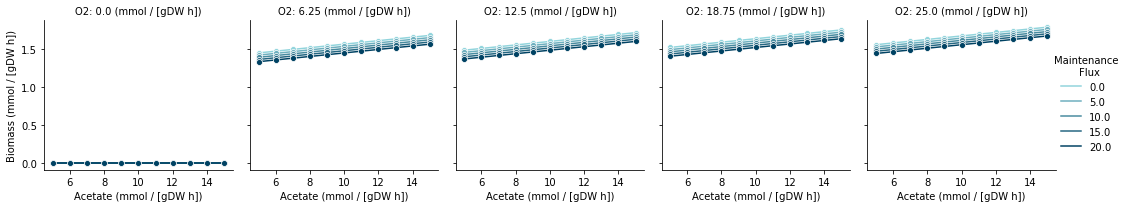

In [269]:
"Visualize biomass"
g = sns.relplot(x='ac', y='biomass', hue='vm', col='o2', data=df, kind='line', marker='o', height=3, palette=cmap2)
g.set_axis_labels("Acetate (mmol / [gDW h])", "Biomass (mmol / [gDW h])")
g.set_titles("O2: {col_name} (mmol / [gDW h])")
g._legend.set_title('Maintenance\n        Flux')
plt.show()

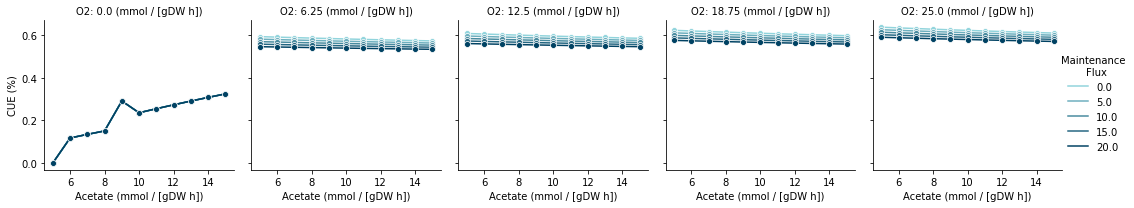

In [268]:
"Visualize CUE"
g = sns.relplot(x='ac', y='cue', hue='vm', col='o2', data=df, kind='line', marker='o', height=3, palette=cmap2)
g.set_axis_labels("Acetate (mmol / [gDW h])", "CUE (%)")
g.set_titles("O2: {col_name} (mmol / [gDW h])")
g._legend.set_title('Maintenance\n        Flux')
plt.show()